## 互评作业三


代码地址：
使用数据集：Hotel booking demand

问题探索：
 - 基本情况：城市酒店和假期酒店预订需求和入住率比较
 - 用户行为：提前预定时间、入住时长、预定间隔、餐食预定情况
 - 一年中最佳预定酒店时间
 - 利用Logistic预测酒店预订

In [69]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import collections

In [32]:
# 数据信息以及缺失值筛选
data = pd.read_csv("hotel_bookings.csv")
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [33]:
data.shape
data.dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [34]:
data.isnull().any()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                           True
babies                            False
meal                              False
country                            True
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                              True
company                            True


In [35]:
# 含有缺失值的字段有多少缺失值
def count_nan(attr_name):
    return data[attr_name].isnull().sum(axis=0)
print("children: ", count_nan('children'))
print("country: ", count_nan('country'))
print("agent: ", count_nan('agent'))
print("company: ", count_nan('company'))

children:  4
country:  488
agent:  16340
company:  112593


In [39]:
# 从缺失值情况来看 company 字段下只有200条左右的有效数据 agent 缺失值数量大概在1/5左右 因此这里直接去掉两列数据
data.drop('agent', axis=1, inplace=True)
data.drop('company', axis=1, inplace=True)
data.dropna(axis=0, how='any', inplace=True)
data.isnull().any()
# data.info()

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                          False
babies                            False
meal                              False
country                           False
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
days_in_waiting_list              False
customer_type                     False


- 城市酒店和假期酒店需求和入住情况比较

In [40]:
print(set(data['hotel']))

{'Resort Hotel', 'City Hotel'}


In [57]:
city_hotel_total = (data['hotel'] == 'City Hotel').sum()
resort_hotel_total = (data['hotel'] == 'Resort Hotel').sum()
print(city_hotel_total)
print(resort_hotel_total)

city_hotel_real = len(data[(data['hotel'] == 'City Hotel') & (data['is_canceled'] == 0)])
resort_hotel_real = len(data[(data['hotel'] == 'Resort Hotel') & (data['is_canceled'] == 0)])
print(city_hotel_real)
print(resort_hotel_real)

79302
39596
46226
28519


In [58]:
print("城市酒店入住率：", city_hotel_real / city_hotel_total)
print("假期酒店入住率：", resort_hotel_real / resort_hotel_total)

城市酒店入住率： 0.5829108975813977
假期酒店入住率： 0.7202495201535508


- 提前预定时间、入住时长、预定间隔、餐食预定情况

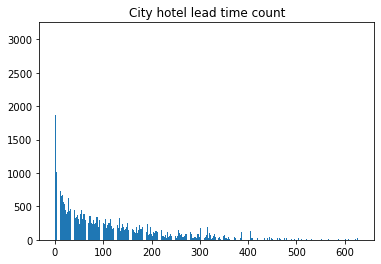

In [73]:
# 提前预订时间情况
city_hotel_lead_time = data[(data['hotel']=='City Hotel')]['lead_time']

res = dict(collections.Counter(city_hotel_lead_time))
plt.figure()
plt.title('City hotel lead time count')
plt.bar(res.keys(), res.values())
plt.show()

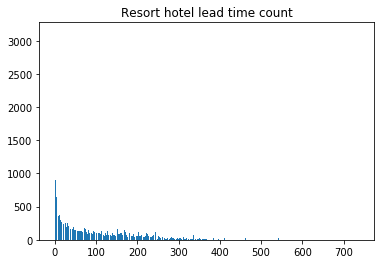

In [74]:
resort_hotel_lead_time = data[(data['hotel']=='Resort Hotel')]['lead_time']

res = dict(collections.Counter(resort_hotel_lead_time))
plt.figure()
plt.title('Resort hotel lead time count')
plt.bar(res.keys(), res.values())
plt.show()

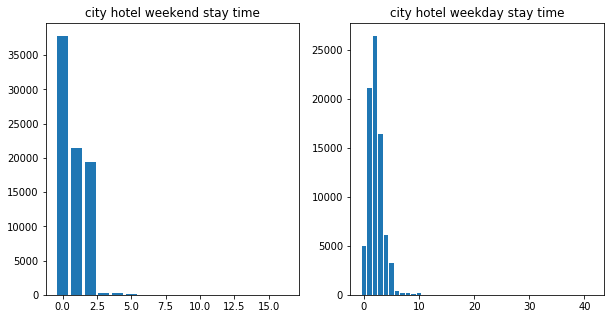

In [80]:
# 入住时常
city_hotel_stay_time_weekend = data[data['hotel']=='City Hotel']['stays_in_weekend_nights']
city_hotel_stay_time_weekday = data[data['hotel']=='City Hotel']['stays_in_week_nights']
weekend_res = dict(collections.Counter(city_hotel_stay_time_weekend))
weekday_res = dict(collections.Counter(city_hotel_stay_time_weekday))

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax1.bar(weekend_res.keys(), weekend_res.values())
ax1.set_title('city hotel weekend stay time')

ax2 = plt.subplot(122)
ax2.bar(weekday_res.keys(), weekday_res.values())
ax2.set_title('city hotel weekday stay time')

plt.show()

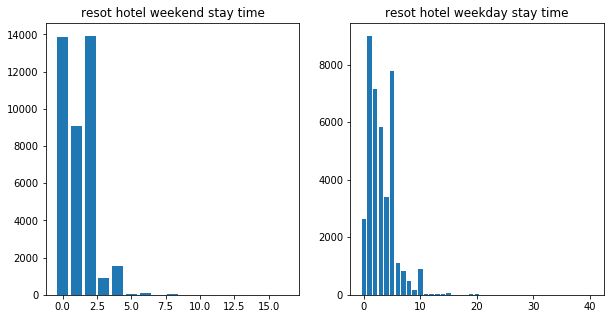

In [82]:
resot_hotel_stay_time_weekend = data[data['hotel']=='Resort Hotel']['stays_in_weekend_nights']
resot_hotel_stay_time_weekday = data[data['hotel']=='Resort Hotel']['stays_in_week_nights']
weekend_res = dict(collections.Counter(resot_hotel_stay_time_weekend))
weekday_res = dict(collections.Counter(resot_hotel_stay_time_weekday))

plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax1.bar(weekend_res.keys(), weekend_res.values())
ax1.set_title('resot hotel weekend stay time')

ax2 = plt.subplot(122)
ax2.bar(weekday_res.keys(), weekday_res.values())
ax2.set_title('resot hotel weekday stay time')

plt.show()

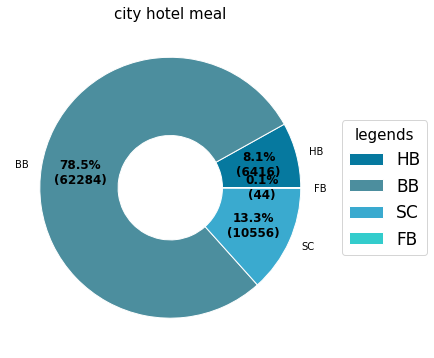

In [97]:
# 餐饮比例情况
city_hotel_meal = data[data['hotel']=='City Hotel']['meal']
meal_res = dict(collections.Counter(city_hotel_meal))

recipe_labels = np.array(list(meal_res.keys()))
recipe_data = np.array(list(meal_res.values()))

# 用来规定输出格式的函数
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
colors=['#06799f', '#4c8e9e','#3aaacf','#33cccc', '#91cdcb']
fig, ax = plt.subplots(figsize=(12, 6))
wedges, texts, autotexts = ax.pie(x=recipe_data,
                                  labels=recipe_labels,
                                  autopct=lambda pct: func(pct ,recipe_data),
                                  colors=colors,
                                  pctdistance=0.7,
                                  wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor':'w'}
                                  )
ax.legend(wedges, recipe_labels,
          title="legends",
          title_fontsize=15,
          fontsize=17,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("city hotel meal", fontdict={'fontsize':15, 'fontweight':15})
plt.show()

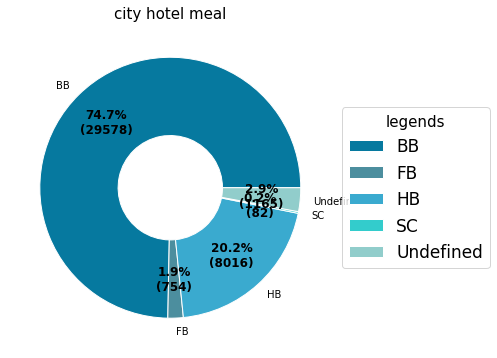

In [99]:
resort_hotel_meal = data[data['hotel']=='Resort Hotel']['meal']
meal_res = dict(collections.Counter(resort_hotel_meal))

recipe_labels = np.array(list(meal_res.keys()))
recipe_data = np.array(list(meal_res.values()))

# 用来规定输出格式的函数
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
colors=['#06799f', '#4c8e9e','#3aaacf','#33cccc', '#91cdcb']
fig, ax = plt.subplots(figsize=(12, 6))
wedges, texts, autotexts = ax.pie(x=recipe_data,
                                  labels=recipe_labels,
                                  autopct=lambda pct: func(pct ,recipe_data),
                                  colors=colors,
                                  pctdistance=0.7,
                                  wedgeprops = {'width': 0.6, 'linewidth': 1, 'edgecolor':'w'}
                                  )
ax.legend(wedges, recipe_labels,
          title="legends",
          title_fontsize=15,
          fontsize=17,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")
ax.set_title("city hotel meal", fontdict={'fontsize':15, 'fontweight':15})
plt.show()

- 一年中最佳预订时间

对于城市酒店，由之前的预订时间数据可以看出，大部分预订时间都是0，1，也就是大部分人都会提前一天或者当天预订，结合城市酒店的功能往往是对于突发情况下需要住宿的人提供服务，因此城市酒店并没有最佳预订时间可言。

对于假期酒店，由预定时间可以看出在0~100天之间都是预订较多的时间，并且实际入住率达到了70%，取消情况相对较低，因此尽量在假期来临之前三个月左右预订酒店。

- 利用Logistic预测酒店预订

数据中提供的全部是预订数据 同时提供了 is_canceled 数据， 结合后面的时间、家庭成员以及餐饮等等数据来看，可以将预订的是否取消作为其他一系列因素的作用结果，即将日期、时常以及成员人数等字段看作特征，共同决定了预订是否取消这一结果

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [114]:
# 将字符串字段映射为数值
data_cp = pd.DataFrame()
data_cp["is_canceled"] = data["is_canceled"]
data_cp['hotel'] = data['hotel'].map({'Resort Hotel':0, 'City Hotel':1})
data_cp['arrival_date_month'] = data['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
data_cp["total_nights"] = data["stays_in_weekend_nights"]+ data["stays_in_week_nights"]
data_cp["total_customer"] = data["adults"]+ data["babies"]
data_cp.dropna(axis=0, how='any', inplace=True)
print(data_cp.isnull().sum())

is_canceled           0
hotel                 0
arrival_date_month    0
total_nights          0
total_customer        0
dtype: int64


In [118]:
# 划分训练以及测试数据集
y = data_cp["is_canceled"]
X = data_cp.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Accuracy Score: '，accuracy_score(y_test,y_pred))


Accuracy Score: 0.6254835996635828

Confusion Matrix:
 [[22163   155]
 [13204   148]]


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
